<a href="https://colab.research.google.com/github/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/blob/master/starter_notebook_11_14_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
"""
you will be forecasting real estate prices of various zip codes 

What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
print('Colab Notebook 11-15-12')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

Colab Notebook 11-11-12


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
# #pd.set_option('display.max_columns', None)  
# zillow = pd.read_csv('zillow_data.csv')
# zillow.head()
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
zillow = pd.read_csv('/content/gdrive/My Drive/data/zillow_data.csv') 

In [5]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,78100.0,78200.0,78400.0,78600.0,78800.0,79000.0,79100.0,79200.0,79300.0,79300.0,79300.0,79400.0,79500.0,79500.0,79600.0,...,114700,115000,115000,115200,115600,115900,115600,115400,115400,115500,115800,116300,116200,115600,115000,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [7]:
all_zipcodes = melt_data(zillow)

In [8]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [9]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [10]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [11]:
test_dict = {}

# for zipcode in kings_zips['Zipcode'].unique(): 
#     all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
#     all_zips = all_zips.set_index('Month')['MeanValue']
#     all_zips = all_zips.asfreq('MS')
#     all_zips.name = zipcode
#     test_dict[zipcode] = all_zips
for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [12]:
test_dict

{11203: Month
 1996-04-01    149000.0
 1996-05-01    149200.0
 1996-06-01    149400.0
 1996-07-01    149600.0
 1996-08-01    149700.0
                 ...   
 2017-12-01    474500.0
 2018-01-01    475300.0
 2018-02-01    474800.0
 2018-03-01    481000.0
 2018-04-01    489900.0
 Freq: MS, Name: 11203, Length: 265, dtype: float64, 11204: Month
 1996-04-01    201100.0
 1996-05-01    201100.0
 1996-06-01    201100.0
 1996-07-01    201100.0
 1996-08-01    201100.0
                 ...   
 2017-12-01    958900.0
 2018-01-01    963200.0
 2018-02-01    967900.0
 2018-03-01    972800.0
 2018-04-01    976400.0
 Freq: MS, Name: 11204, Length: 265, dtype: float64, 11205: Month
 2004-01-01     833100.0
 2004-02-01     821400.0
 2004-03-01     812000.0
 2004-04-01     805500.0
 2004-05-01     801400.0
                 ...    
 2017-12-01    2251000.0
 2018-01-01    2251600.0
 2018-02-01    2245300.0
 2018-03-01    2243700.0
 2018-04-01    2248400.0
 Freq: MS, Name: 11205, Length: 172, dtype: float64

In [13]:
zip_df = pd.concat(test_dict, axis=1)

In [14]:
len(zip_df)

265

In [15]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,133200.0,124500.0,160900.0,177200.0,207600.0,126800.0,201100.0,213200.0,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,132900.0,124500.0,161000.0,177000.0,208000.0,126700.0,201100.0,212600.0,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,132500.0,124500.0,161200.0,176800.0,208400.0,126700.0,201100.0,211900.0,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,132200.0,124500.0,161300.0,176700.0,208800.0,126600.0,201100.0,211300.0,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,131800.0,124700.0,161500.0,176800.0,209300.0,126600.0,201100.0,210800.0,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [16]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,1463100.0,809800.0,453600.0,1186400.0,947800.0,435400.0,958900.0,1016000.0,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,1496100.0,800800.0,458400.0,1174500.0,952100.0,429900.0,963200.0,1014400.0,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,1531100.0,806100.0,461600.0,1173900.0,966600.0,432300.0,967900.0,1023800.0,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,1581900.0,829200.0,467200.0,1196100.0,997000.0,442400.0,972800.0,1053000.0,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,1623700.0,852300.0,472000.0,1220900.0,1026600.0,450600.0,976400.0,1079600.0,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [17]:
#zip_df[11238]
zip_df = zip_df[[11226,11238]]

In [18]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [19]:
zip_df.isna().sum()

11226     0
11238    93
dtype: int64

In [20]:
zip_df.bfill(inplace=True)

In [21]:
zip_df.isna().sum()

11226    0
11238    0
dtype: int64

In [22]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [23]:
zip_df.keys()

Int64Index([11226, 11238], dtype='int64')

In [24]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

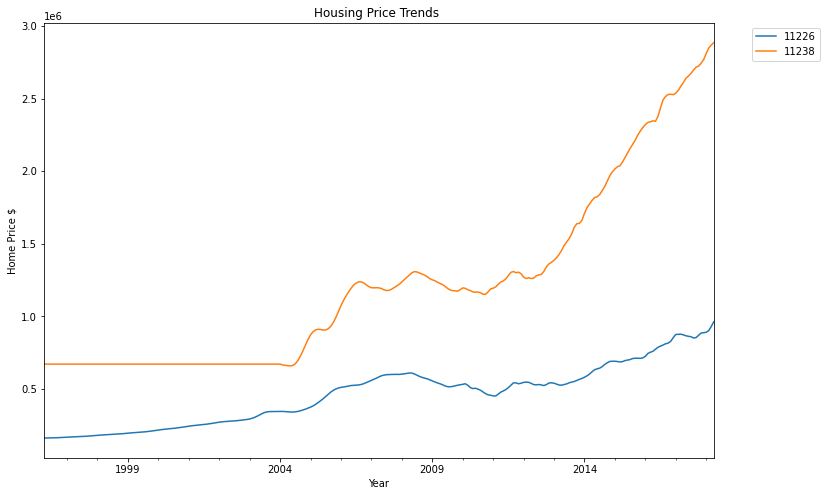

In [25]:
"""

2007–08 Housing Market Crash
"""
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Price $')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

## **Train/Test Split**

In [26]:
"""
 test data set is from 2015–01–01 to 2018–01–01. The length of our test data we get 37 rows, or 37 time periods. 
 That is the value we will use for our .predict() method 

"""
year = '01-01-2014'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [27]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 2)
(52, 2)


In [28]:
train_brk.head(10)

,11226,11238
Month,,
1996-04-01,162000.0,671200.0
1996-05-01,162300.0,671200.0
1996-06-01,162600.0,671200.0
1996-07-01,163000.0,671200.0
1996-08-01,163400.0,671200.0
1996-09-01,164000.0,671200.0
1996-10-01,164700.0,671200.0
1996-11-01,165700.0,671200.0
1996-12-01,166800.0,671200.0


In [29]:
train_brk[11226]

Month
1996-04-01    162000.0
1996-05-01    162300.0
1996-06-01    162600.0
1996-07-01    163000.0
1996-08-01    163400.0
                ...   
2013-09-01    551600.0
2013-10-01    558900.0
2013-11-01    566200.0
2013-12-01    572600.0
2014-01-01    580700.0
Freq: MS, Name: 11226, Length: 214, dtype: float64

In [30]:
test_brk[11226].head()

Month
2014-01-01    580700.0
2014-02-01    590500.0
2014-03-01    602600.0
2014-04-01    618300.0
2014-05-01    632300.0
Freq: MS, Name: 11226, dtype: float64

### **Auto_Arima Model**

In [31]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [32]:
!pip install pmdarima

In [33]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [34]:
#stepwise_fit = auto_arima(train_brk[11220],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 1, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=1, D=1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    display(autoarima_model.summary())
    
    #print(autoarima_model.plot_diagnostics(figsize=(12,10)))
    
    return autoarima_model

    #autoarima_model.summary()

In [35]:
stepwise_fit = arima_model(train_brk[11226])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4186.338, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4111.966, Time=1.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4116.531, Time=1.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4211.321, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4147.894, Time=1.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4104.096, Time=1.08 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=4132.912, Time=1.69 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=6.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4162.447, Time=0.23 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4158.454, Time=0.54 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4092.751, Time=2.67 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4127.548, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -2038.094
Date:                                 Sun, 15 Nov 2020   AIC                           4086.188
Time:                                         15:46:52   BIC                           4102.705
Sample:                                              0   HQIC                          4092.871
                                                 - 214                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7137      0.058     12.407      0.000       0.601       0.826
ma.L1         -0.4503      0.059     -7.686      0.000      -0.565      -0.335
ma.S.L12      -0.3650      0.023    -15.883      0.000      -0.410      -0.320
ma.S.L24      -0.1213      0.014     -8.872      0.000      -0.148      -0.095
sigma2      3.688e+07   1.65e-10   2.23e+17      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (Q):                      181.53   Jarque-Bera (JB):               133.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+32. Standard errors may be unstable.
"""

In [36]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -2038.094
Date:                                 Sun, 15 Nov 2020   AIC                           4086.188
Time:                                         15:46:52   BIC                           4102.705
Sample:                                              0   HQIC                          4092.871
                                                 - 214                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7137      0.058     12.407      0.000       0.601       0.826
ma.L1         -0.4503      0.059     -7.686      0.000      -0.565      -0.335
ma.S.L12      -0.3650      0.023    -15.883      0.000      -0.410      -0.320
ma.S.L24      -0.1213      0.014     -8.872      0.000      -0.148      -0.095
sigma2      3.688e+07   1.65e-10   2.23e+17      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (Q):                      181.53   Jarque-Bera (JB):               133.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+32. Standard errors may be unstable.
"""

In [37]:
#length of test data
#periods months
# future_forecast = stepwise_fit.predict(n_periods=52)
# print(future_forecast)

In [38]:
# future_forecast = pd.DataFrame(future_forecast,index = test_brk.index,columns=['Prediction'])
# pd.concat([train_brk[11226],future_forecast],axis=1).plot()

In [39]:
# plt.figure(figsize=(12,5))
# plt.plot(train_brk[11226], label='Train')
# plt.plot(test_brk[11226],label='Test')
# plt.plot(future_forecast,label='Predicted')
# plt.legend()

In [40]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# mse = mean_squared_error(test_brk[11226], future_forecast)
# rmse = sqrt(mse)
# print(rmse)

In [41]:
#test_brk[11226].describe()

In [42]:
"""
arima_dic_2 = {}
for col in df_zip.columns:
    stepwise_fit = auto_arima(df_zip[col],start_p = 1, start_q = 1,max_p = 3, max_q = 3, m = 12,trace = True, stepwise = True)
    best_AIC = stepwise_fit.aic() #extracting the best
    arima_dic_2[col] = best_AIC  #using the dictionary to set best AIC for each zipcode
output = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode','Best AIC'])
output
"""
arima_dic_2 = {}
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  best_AIC = zip_test_2.aic() #extracting the best
  arima_dic_2[col] = best_AIC

output = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode','Best AIC'])
output     

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=0.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=1.74 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=0.96 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=3.93 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=3.78 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.04 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.92 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2593.046
Date:                              Sun, 15 Nov 2020   AIC                           5194.092
Time:                                      15:47:27   BIC                           5208.210
Sample:                                           0   HQIC                          5199.773
                                              - 265                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.65 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.28 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=1.72 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.04 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.23 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=2.01 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.27 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=3.07 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2795.831
Date:                                 Sun, 15 Nov 2020   AIC                           5603.661
Time:                                         15:49:09   BIC                           5624.838
Sample:                                              0   HQIC                          5612.182
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

,Zipcode,Best AIC
0,11226,5194.092117
1,11238,5603.661287


In [43]:
output

,Zipcode,Best AIC
0,11226,5194.092117
1,11238,5603.661287


In [44]:
arima_dic_2 = {}
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  arima_dic_2[col] = zip_test_2
  
output_2 = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode_pdq','pdq']) 
output_2   

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=0.88 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=1.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=0.98 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=3.90 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=3.60 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.07 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.86 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2593.046
Date:                              Sun, 15 Nov 2020   AIC                           5194.092
Time:                                      15:49:43   BIC                           5208.210
Sample:                                           0   HQIC                          5199.773
                                              - 265                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.65 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.25 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=1.70 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.04 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.15 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=1.96 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.27 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=2.95 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2795.831
Date:                                 Sun, 15 Nov 2020   AIC                           5603.661
Time:                                         15:51:26   BIC                           5624.838
Sample:                                              0   HQIC                          5612.182
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

,Zipcode_pdq,pdq
0,11226,"ARIMA(1,1,0)(1,1,1)[12]"
1,11238,"ARIMA(0,1,1)(1,1,2)[12] intercept"


In [45]:
#output_2.rename(columns = {0:'Zipcode',1:'pdq'}, inplace = True)
output_2 

,Zipcode_pdq,pdq
0,11226,"ARIMA(1,1,0)(1,1,1)[12]"
1,11238,"ARIMA(0,1,1)(1,1,2)[12] intercept"


In [46]:
output_2['Zipcode_pdq']

0    11226
1    11238
Name: Zipcode_pdq, dtype: int64

In [47]:
result = pd.concat([output_2, output], axis=1, sort=False)

In [48]:
result

,Zipcode_pdq,pdq,Zipcode,Best AIC
0,11226,"ARIMA(1,1,0)(1,1,1)[12]",11226,5194.092117
1,11238,"ARIMA(0,1,1)(1,1,2)[12] intercept",11238,5603.661287


## **SARIMA Model**

In [49]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [50]:
"""
(AIC) is an estimator of the relative quality of statistical models for a given set of data. 
Given a collection of models for the data, AIC estimates the quality of each model, relative to each of 
    the other models. AIC provides a means for model selection.

Model that fits the data very well while using lots of features will be assigned a larger AIC score than a model
    that uses fewer features to achieve the same goodness-of-fit. 
    We are interested in finding the model that yields the lowest AIC value. 

  
"""
#Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def gridsearch_pdq(pdq, pdqs, df):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
                
            except:
                continue
   
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    #ans_df.loc[ans_df['aic'].idxmin()]

    
    return ans_df          

In [51]:
gs_pdq = gridsearch_pdq(pdq, pdqs,train_brk[11238])
gs_pdq

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6494.86192320497
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5435288.013271321
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5258.721610483122
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4958.137605636741
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5235.181694849835
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5212.334802654393
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4956.129551147376
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4932.74625491031
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =460934.71656952595
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =5428569.606888281
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5358.686359532996
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4788.05268893257
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6474.542504150766
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6331.279346997606
ARIMA (0, 0, 1) x (1, 

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",6.494862e+03
1,"(0, 0, 0)","(0, 0, 1, 12)",5.435288e+06
2,"(0, 0, 0)","(0, 1, 0, 12)",5.258722e+03
3,"(0, 0, 0)","(0, 1, 1, 12)",4.958138e+03
4,"(0, 0, 0)","(1, 0, 0, 12)",5.235182e+03
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",3.847032e+03
60,"(1, 1, 1)","(1, 0, 0, 12)",4.007403e+03
61,"(1, 1, 1)","(1, 0, 1, 12)",3.988570e+03
62,"(1, 1, 1)","(1, 1, 0, 12)",3.867012e+03


In [52]:
 gs_pdq.sort_values(by='aic')

,pdq,pdqs,aic
59,"(1, 1, 1)","(0, 1, 1, 12)",3.847032e+03
63,"(1, 1, 1)","(1, 1, 1, 12)",3.848383e+03
62,"(1, 1, 1)","(1, 1, 0, 12)",3.867012e+03
54,"(1, 1, 0)","(1, 1, 0, 12)",3.915794e+03
55,"(1, 1, 0)","(1, 1, 1, 12)",3.917533e+03
...,...,...,...
0,"(0, 0, 0)","(0, 0, 0, 12)",6.494862e+03
15,"(0, 0, 1)","(1, 1, 1, 12)",8.890689e+03
8,"(0, 0, 1)","(0, 0, 0, 12)",4.609347e+05
9,"(0, 0, 1)","(0, 0, 1, 12)",5.428570e+06


In [53]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(gs_pdq, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3847.03
Name: 59, dtype: object

### **Fitting an ARIMA TS Model**

In [54]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 
plug in the optimal parameter values into a new SARIMAX model.    

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.
-----------------------
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(CO2, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])


"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6873      0.045     15.420      0.000       0.600       0.775
ma.L1          0.3540      0.031     11.303      0.000       0.293       0.415
ar.S.L12      -0.3288      0.071     -4.603      0.000      -0.469      -0.189
ma.S.L12      -0.0368      0.058     -0.633      0.527      -0.151       0.077
sigma2      8.221e+07   2.84e-10    2.9e+17      0.000    8.22e+07    8.22e+07


MODEL DIAGNOSTICS


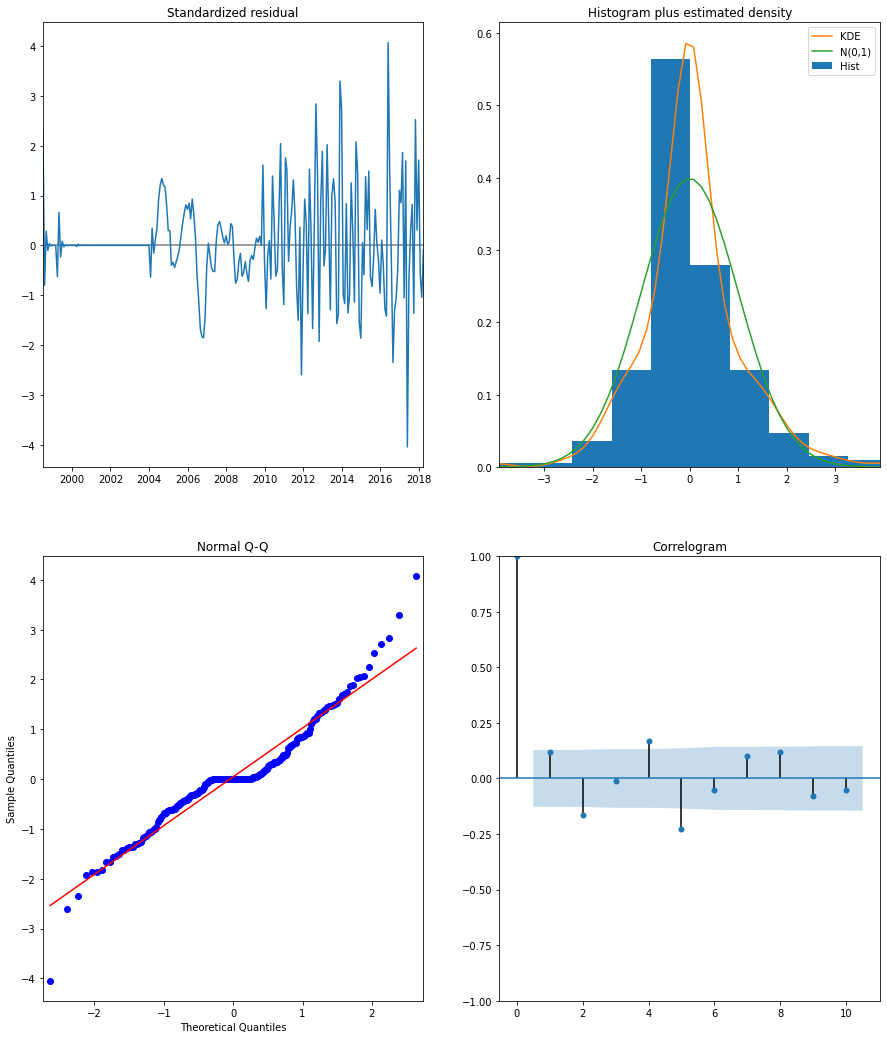

In [55]:
#11235	ARIMA(2,1,0)(0,1,0)[12]	
#11238	ARIMA(0,1,1)(1,1,2)[12] 
output_su = fit_ARIMA(zip_df[11238], order=(1,1,1), seasonal_order=(1,1,1,12))

### **Validating the Model**

#### **One-Step Ahead Forecasting**

In [56]:
# ans_df = pd.DataFrame(gs_pdq, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]

In [57]:
"""
start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

get_prediction() and .conf_int() methods allow us to obtain the values and associated confidence intervals for forecasts of the time series.
Get the confidence intervals for all predictions

plot the real and forecasted values of the time series to assess how well we did

pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()
"""
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_su.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

In [58]:
pred_conf

,lower 11238,upper 11238
Month,,
2016-01-01,2.311733e+06,2.347275e+06
2016-02-01,2.312395e+06,2.393185e+06
2016-03-01,2.302481e+06,2.429480e+06
2016-04-01,2.305329e+06,2.476974e+06
2016-05-01,2.311142e+06,2.524950e+06
2016-06-01,2.314008e+06,2.567266e+06
2016-07-01,2.320503e+06,2.610569e+06
2016-08-01,2.331039e+06,2.655468e+06
2016-09-01,2.343588e+06,2.700179e+06


In [59]:
train_brk[11226]

Month
1996-04-01    162000.0
1996-05-01    162300.0
1996-06-01    162600.0
1996-07-01    163000.0
1996-08-01    163400.0
                ...   
2013-09-01    551600.0
2013-10-01    558900.0
2013-11-01    566200.0
2013-12-01    572600.0
2014-01-01    580700.0
Freq: MS, Name: 11226, Length: 214, dtype: float64

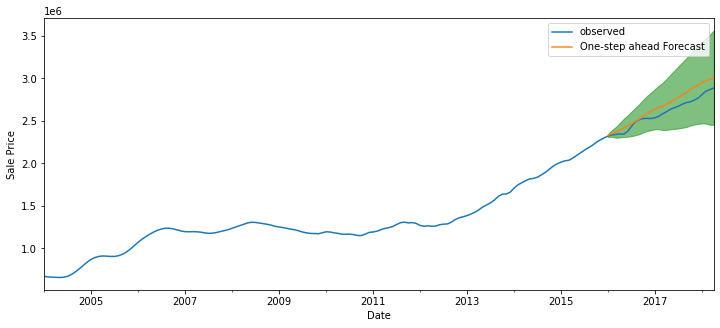

In [60]:
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
#ax = brooklyn_zips[11238]['2004':].plot(label='observed')
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [61]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = zip_df[11238]['2004':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 8750875016.43
The Root Mean Squared Error of our forecasts is 93546.11


In [62]:
pred = output_su.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

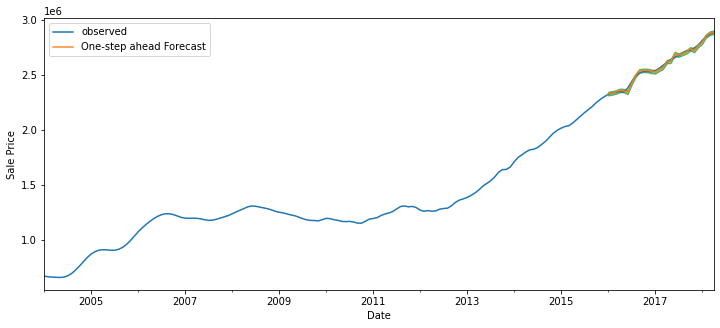

In [63]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


In [64]:
# pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
# pred_ci = pred.conf_int()
# ax = train_brk[11238]['1996':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('Date')
# ax.set_ylabel('Amount_Houses_sold')
# plt.legend()
# plt.show()

In [65]:
#length of test data
#periods months
future_forecast = stepwise_fit.predict(n_periods=52)
print(future_forecast)

[580724.1576134  579950.03998671 580926.45461067 584436.45161974
 589236.85256838 595904.01106835 600381.92252324 604254.17983157
 609369.9378673  614341.71261255 619027.21251225 624429.36248986
 624147.98626544 623171.7764644  623112.68063042 624986.1523203
 628858.49608748 634597.27139808 638229.43861702 641188.66539557
 645724.38711894 650406.20077557 654425.77404727 658608.13380476
 657879.04521012 656583.31164745 656296.17781176 658006.90313825
 661763.09793641 667418.97994774 670991.9878033  673908.99367492
 678414.58314396 683074.89198658 687079.11768354 691250.52417027
 690513.61843564 689212.30592957 688921.1905086  690629.07425377
 694383.24106966 700037.6757488  703609.65067104 706525.91935788
 711030.98271224 715690.91607687 719694.87380237 723866.08904298
 723129.04681966 721827.63690421 721536.45196403 723244.28609468]


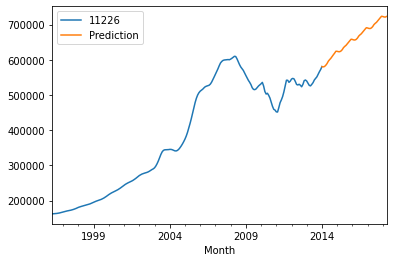

In [66]:
future_forecast = pd.DataFrame(future_forecast,index = test_brk.index,columns=['Prediction'])
pd.concat([train_brk[11226],future_forecast],axis=1).plot()

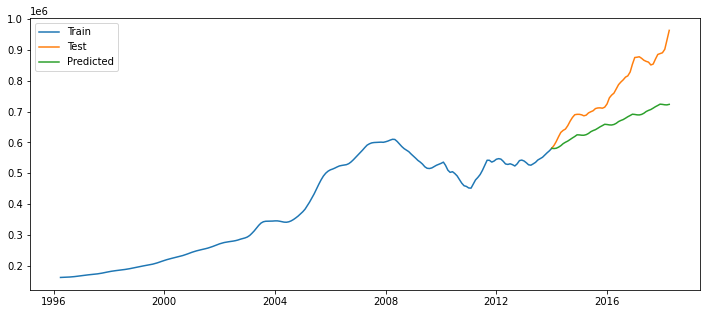

In [67]:
plt.figure(figsize=(12,5))
plt.plot(train_brk[11226], label='Train')
plt.plot(test_brk[11226],label='Test')
plt.plot(future_forecast,label='Predicted')
plt.legend()

In [68]:
test_brk[11226].describe()

count        52.000000
mean     762953.846154
std       99723.064497
min      580700.000000
25%      689500.000000
50%      748750.000000
75%      860800.000000
max      963200.000000
Name: 11226, dtype: float64

In [69]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_brk[11226], future_forecast)
rmse = sqrt(mse)
print(rmse)

119862.58066771938


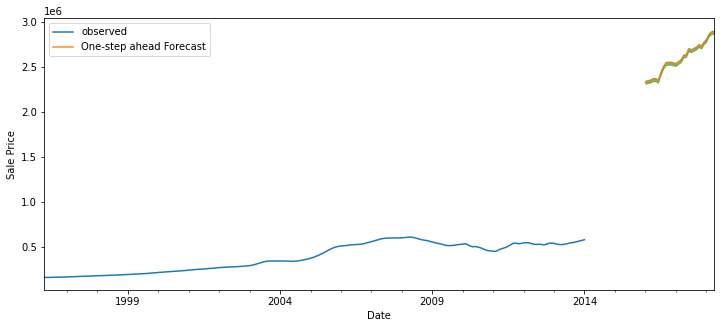

In [70]:
"""
plot the real and forecasted values of the CO2 time series to assess how well we did:

Plot the observed values from the dataset, starting at 1990
Use .predicted_mean.plot() method to plot predictions
Plot the confidence intervals overlapping the predicted values

"""

# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = train_brk[11226].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [71]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = train_brk[11226]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is nan
The Root Mean Squared Error of our forecasts is nan


In [72]:
"""
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()
"""
pred = output_su.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower 11238,upper 11238
Month,,
2016-01-01,2.311733e+06,2.347275e+06
2016-02-01,2.317251e+06,2.352793e+06
2016-03-01,2.326208e+06,2.361751e+06
2016-04-01,2.340695e+06,2.376238e+06
2016-05-01,2.339027e+06,2.374570e+06
2016-06-01,2.323608e+06,2.359150e+06
2016-07-01,2.406616e+06,2.442158e+06
2016-08-01,2.476071e+06,2.511613e+06
2016-09-01,2.518843e+06,2.554385e+06


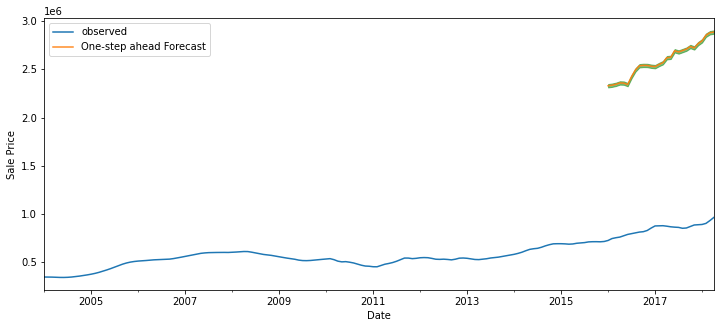

In [73]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11226]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()

## ***Stationarity***

### Zipcode: 11217

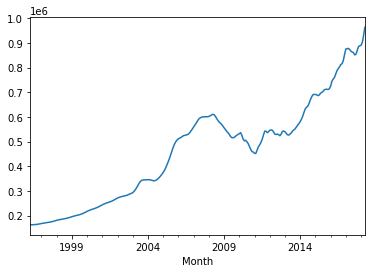

In [74]:
zip_df[11226].plot()

In [75]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

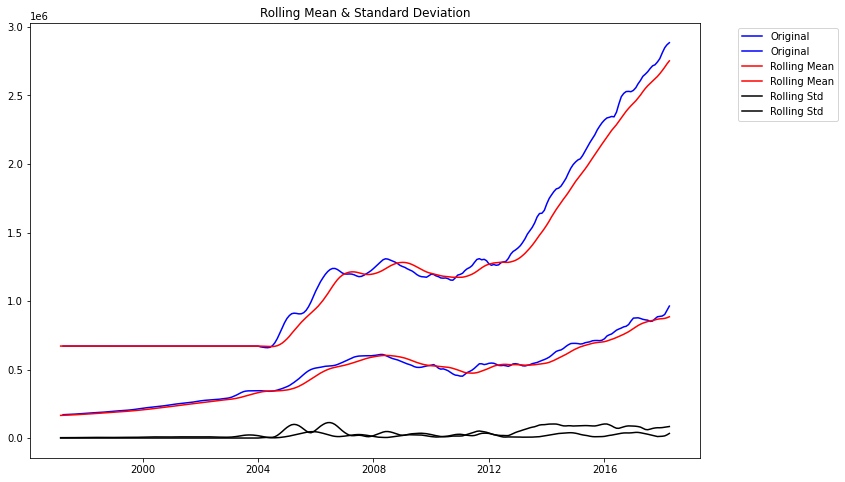

In [76]:
test_stationarity_1(zip_df,12)

In [77]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [78]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

(0.6254102589740158, 0.9882254867110694, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 4684.550681605726)
Results of Dickey-Fuller Test:
(1.3300142358520664, 0.9967718123702427, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 5045.970907033796)
Results of Dickey-Fuller Test:


In [79]:
new_dic[11226]

Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

In [80]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [81]:
dickey_fuller_test_zipcodes(zip_df)

Results of Dickey-Fuller Test:
Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                   1.330014
p-value                          0.996772
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64




In [82]:
X_1 = zip_df.copy()

In [83]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.6254102589740158
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.62541,0.988225,15,249,False


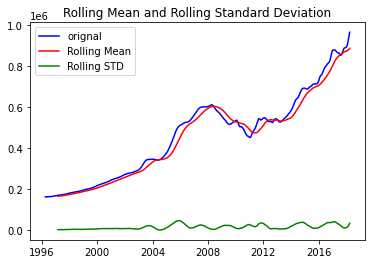

In [84]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [85]:
#brooklyn_zips[11226]

In [86]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

ADF statistic: 0.6254102589740158
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.62541,0.988225,15,249,False


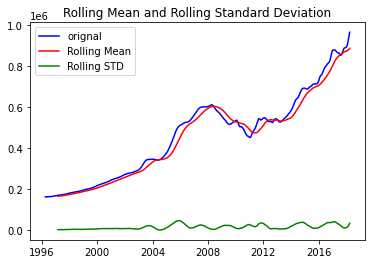

In [87]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: -0.8965122806314395
p-value: 0.7891188037192421
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-0.896512,0.789119,15,249,False


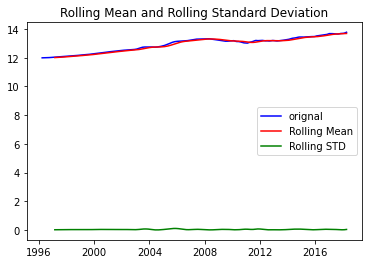

In [88]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -2.0776022749420107
p-value: 0.2536156786996234
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-2.077602,0.253616,14,249,False


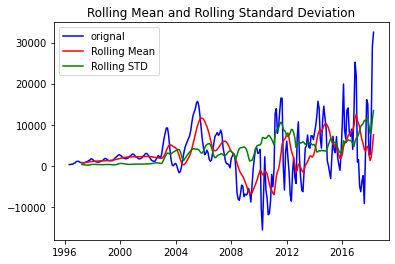

In [89]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.6919221784675216
p-value: 0.43527914575985843
Critical Values:
	1% : -3.457215237265747
	5% : -2.873361841566324
	10% : -2.5730700760129555


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.691922,0.435279,16,246,False


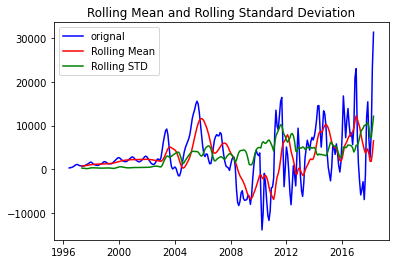

In [90]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -1.386161098795962
p-value: 0.5888923863309314
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.386161,0.588892,15,249,False


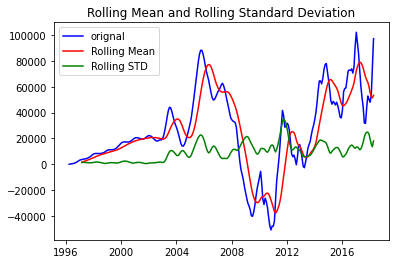

In [91]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

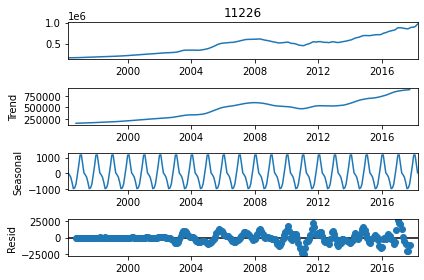

In [92]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

ADF statistic: -861210761297677.1
p-value: 0.0
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-8.612108e+14,0.0,15,249,True


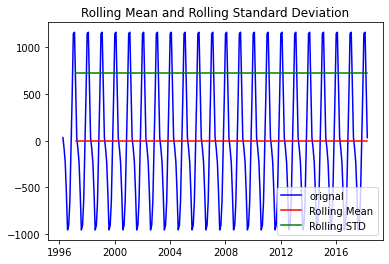

In [93]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 0.70406044441254
p-value: 0.9899185553239883
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.70406,0.989919,16,236,False


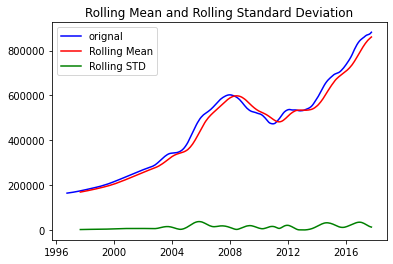

In [94]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -4.680890205249196
p-value: 9.139086370903546e-05
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-4.68089,0.000091,16,236,True


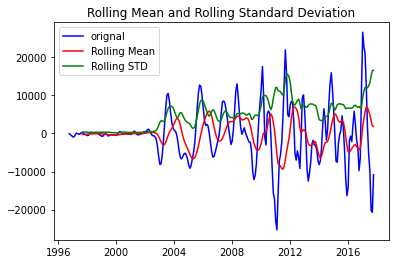

In [95]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [96]:
decomp.resid.dropna()

Month
1996-10-01      -66.765873
1996-11-01     -359.478716
1996-12-01     -561.859668
1997-01-01     -915.827922
1997-02-01     -855.113636
                  ...     
2017-06-01    -5596.978716
2017-07-01    -9750.550144
2017-08-01   -20252.534271
2017-09-01   -20681.700938
2017-10-01   -10825.099206
Freq: MS, Name: resid, Length: 253, dtype: float64

### Creating a SARIMA TS Model

In [97]:
"""
start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

plot the real and forecasted values of the time series to assess how well we did

"""
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_su.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

In [98]:
pred_conf

,lower 11238,upper 11238
Month,,
2016-01-01,2.311733e+06,2.347275e+06
2016-02-01,2.312395e+06,2.393185e+06
2016-03-01,2.302481e+06,2.429480e+06
2016-04-01,2.305329e+06,2.476974e+06
2016-05-01,2.311142e+06,2.524950e+06
2016-06-01,2.314008e+06,2.567266e+06
2016-07-01,2.320503e+06,2.610569e+06
2016-08-01,2.331039e+06,2.655468e+06
2016-09-01,2.343588e+06,2.700179e+06


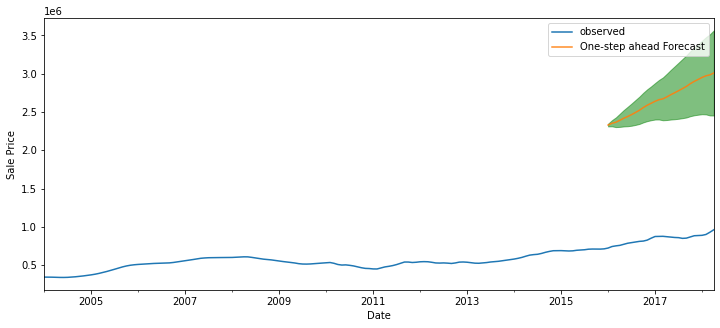

In [99]:
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11226]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [100]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = zip_df[11226]['2004':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 3359349207758.18
The Root Mean Squared Error of our forecasts is 1832852.75


In [101]:
"""
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()
"""
pred = output_su.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

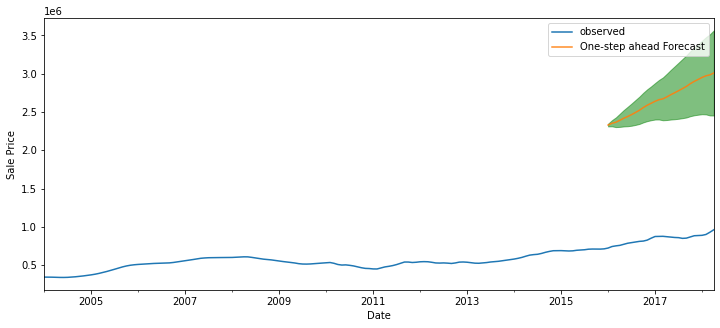

In [102]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11226]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


#### Return on Investment

In [103]:
investment = 40000
rent = 700
loss = 1000  #cost of 1000 per year

def roi(investment, rent, loss):
    """
    return on investment is calcualted by net_profit / investment * 100
    12 = # of months in year 
    investment part doesn't need to be touched investment amount is just capital cost of building
    """
    netprofit = rent * 12 - loss
    ROI = (netprofit / investment) * 100
    print(ROI)
    
#roi(investment, rent, loss) 
#calculated return on investment for these parameters
roi(investment, rent, loss)   

18.5
